## Goal:

### Dataset:https://www.figure-eight.com/data-for-everyone/

This dataset contains labels for the emotional content (such as happiness, sadness, and anger) of texts.
Hundreds to thousands of examples across 13 labels.Data is coolected from twitter.Our goal is to explore data and create a 
model to predict emotion presented in given text.

In [1]:
#Import libraries
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pickle
import re
from collections import Counter
% matplotlib inline

### Get data


In [2]:
dataset = pd.read_csv('text_emotion.csv')

In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 4 columns):
tweet_id     40000 non-null int64
sentiment    40000 non-null object
author       40000 non-null object
content      40000 non-null object
dtypes: int64(1), object(3)
memory usage: 1.2+ MB


In [4]:
dataset.head(5)

,tweet_id,sentiment,author,content
0,1956967341,empty,xoshayzers,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,wannamama,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,coolfunky,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,czareaquino,wants to hang out with friends SOON!
4,1956968416,neutral,xkilljoyx,@dannycastillo We want to trade with someone w...


In [5]:
dataset.sentiment.value_counts()

neutral       8638
worry         8459
happiness     5209
sadness       5165
love          3842
surprise      2187
fun           1776
relief        1526
hate          1323
empty          827
enthusiasm     759
boredom        179
anger          110
Name: sentiment, dtype: int64

### Clean the data:Remove punctuations


In [6]:
features = np.array(dataset.content)
labels = np.array(dataset.sentiment)

In [7]:
from string import punctuation
print(punctuation)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [8]:
def clean_data(features):
    
    clean_features = []
    for feature in features:
        clean_feature = []
        # Replace multiple dots with space
        feature = re.sub('\.\.+', ' ', feature)
        # Remove single dots
        feature = re.sub('\.', '', feature)
        #feature = re.sub('[^ a-zA-Z0-9]', '', feature)
        for word in feature.split():
            if not any(x in word for x in punctuation):
                clean_feature.append(word)
        clean_features.append(clean_feature)
    return clean_features         
        

In [9]:
def preprocess_and_save_data(features,labels):
    features = clean_data(features)
    '''create string of all combined features'''
    complete_text = []
    for feature in features:
        for word in feature:
            complete_text.append(word)
    '''Create vocab and assign number to every word'''      
    from collections import Counter
    counts = Counter(complete_text)
    print('counts Length:{}'.format(len(counts)))
    vocab = sorted(counts,key=counts.get,reverse=True)
    print('voacb Length:{}'.format(len(vocab)))
    '''Start indexing from 1 and not 0 because later we will pad with 0'''
    vocab_int = {word:i for i,word in enumerate(vocab,1)}
    print('vocab_int Length:{}'.format(len(vocab_int)))
    '''Convert features with words to features with integers'''
    int_features = []
    for feature in features:
        int_feature = []
        for word in feature:
            int_feature.append(vocab_int[word])
        int_features.append(int_feature)
        
    '''Remove features with zero length'''
    non_zero_idx = [ii for ii, feature in enumerate(int_features ) if len(feature) != 0]
    int_features = [int_features[ii] for ii in non_zero_idx]
    labels = np.array([labels[ii] for ii in non_zero_idx])
    
    '''Encode labels'''
    labels = pd.get_dummies(labels)
    '''save preprocessed data'''
    
    pickle.dump((int_features,labels,vocab_int),open('preprocess.p', 'wb'))

        

In [10]:
def load_preprocessed_data():
    return pickle.load(open('preprocess.p', mode='rb'))

In [11]:
preprocess_and_save_data(features,labels)

counts Length:33746
voacb Length:33746
vocab_int Length:33746


In [12]:
int_features,labels,vocab_int = load_preprocessed_data()

### Clean Data:Decide length of feature vecor


In [13]:
feat_lenghts = []
for feature in int_features:
    feat_lenghts.append(len(feature))

(array([ 6179.,  7302.,  6762.,  5647.,  4678.,  4028.,  2931.,  1613.,
          509.,    73.]),
 array([  1. ,   4.1,   7.2,  10.3,  13.4,  16.5,  19.6,  22.7,  25.8,
         28.9,  32. ]),
 <a list of 10 Patch objects>)

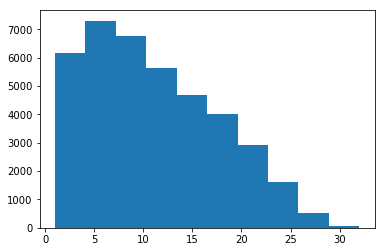

In [14]:
plt.hist(x=feat_lenghts)

In [15]:
'''We will keep size of input vector to 25.For inputs with size less than 25,left pad 0 and for greater than 25,ignore remaining values'''

'We will keep size of input vector to 25.For inputs with size less than 25,left pad 0 and for greater than 25,ignore remaining values'

In [16]:
seq_len = 25
features = np.zeros((len(int_features), seq_len), dtype=int)
for i, row in enumerate(int_features):
    features[i, -len(row):] = np.array(row)[:seq_len]

In [17]:
features[:2]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    7,   48,
           7,   22, 3908,    1,  106, 4916,  891,    6,    7,  577, 1404,
          23,  161,  519],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0, 9061,  303,  142,   19,    4,  444, 4917, 3075,
          14,   37,  271]])

In [18]:
labels[:2]

,anger,boredom,empty,enthusiasm,fun,happiness,hate,love,neutral,relief,sadness,surprise,worry
0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,1,0,0


### Create training and test set

In [19]:
len(features)

39722

In [20]:
split_frac_train = 0.75
training_ids = int(len(features)*split_frac_train)
x_train,x_val = features[:training_ids], features[training_ids:]
y_train,y_val = labels[:training_ids], labels[training_ids:]

split_frac_test = 0.5
testing_ids = int(len(x_val)*split_frac_test)
x_val,x_test = x_val[:testing_ids], x_val[testing_ids:]
y_val,y_test = y_val[:testing_ids], y_val[testing_ids:]

print('No of features in training set:{}'.format(x_train.shape))
print('No of features in validation set:{}'.format((x_val.shape)))
print('No of features in test set:{}'.format((x_test.shape)))

print('No of labels in training set:{}'.format((y_train.shape)))
print('No of labels in validation set:{}'.format((y_val.shape)))
print('No of labels in test set:{}'.format((y_test.shape)))



No of features in training set:(29791, 25)
No of features in validation set:(4965, 25)
No of features in test set:(4966, 25)
No of labels in training set:(29791, 13)
No of labels in validation set:(4965, 13)
No of labels in test set:(4966, 13)


### Build the graph

In [21]:
#Hyperparameters
lstm_size = 256 #No of LSTM nodes
lstm_layers = 1 #No of LSTM layers
embed_size = 300 #No of embedding nodes
batch_size = 512 #No of features to be fed to network in oe iteration
learning_rate = 0.01 #Learning rate

#Graph dimensions
'''
Assume:
lstm_size = 256 #No of LSTM nodes
lstm_layers = 1 #No of LSTM layers
embed_size = 300 #No of embedding nodes
batch_size = 512 #No of features to be fed to network in oe iteration

Then Dimensions:
input: 512x25
Embd:  512x25x300
LSTM:  512x25x256

But we only care about output of last cell so LSTM:LSTM[:,-1] dim become 512x256
Reshape LSTM output for softmax layer like
lstm output : (512)x256
weight:        256x13
final output:  (512)x13


'''

tf.reset_default_graph()
inputs = tf.placeholder(shape=[None,None],dtype=tf.int32,name='inputs')
targets = tf.placeholder(shape=[None,None],dtype=tf.int32,name='targets')
keep_prob = tf.placeholder(dtype=tf.float32)

### Embeddings

In [22]:
n_words = len(vocab_int)+1
embedding = tf.Variable(tf.random_uniform((n_words,embed_size),-1,1))
embed = tf.nn.embedding_lookup(embedding,inputs)

In [23]:
n_words

33747

In [24]:
embed.shape

TensorShape([Dimension(None), Dimension(None), Dimension(300)])

### LSTM Cell

In [25]:
lstm = tf.contrib.rnn.BasicLSTMCell(num_units=lstm_size)
drop = tf.contrib.rnn.DropoutWrapper(cell=lstm, output_keep_prob=keep_prob)
cell = tf.contrib.rnn.MultiRNNCell(cells=[drop]*lstm_layers)
initial_state = cell.zero_state(batch_size, tf.float32)

### RNN Forward Pass

In [26]:
outputs,final_state = tf.nn.dynamic_rnn(cell=cell,inputs=embed,initial_state=initial_state)

In [27]:
outputs.shape

TensorShape([Dimension(512), Dimension(None), Dimension(256)])

### Output

In [29]:
num_classes = 13
grad_clip=5

seq_output = tf.concat(outputs[:,-1],axis=1)
x = tf.reshape(seq_output, [-1, lstm_size])
# Connect the RNN outputs to a softmax layer
with tf.variable_scope('softmax'):
    softmax_w = tf.Variable(tf.truncated_normal((lstm_size, num_classes), stddev=0.1))
    softmax_b = tf.Variable(tf.zeros(num_classes))

logits = tf.matmul(x, softmax_w) + softmax_b
out = tf.nn.softmax(logits, name='predictions')


# One-hot encode targets and reshape to match logits
#y_one_hot = tf.one_hot(labels, num_classes)
y_reshaped = tf.reshape(targets, logits.get_shape())

# Softmax cross entropy loss
loss = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y_reshaped)
loss = tf.reduce_mean(loss)

# Optimizer for training, using gradient clipping to control exploding gradients
'''tvars = tf.trainable_variables()
grads, _ = tf.clip_by_global_norm(tf.gradients(loss, tvars), grad_clip)
train_op = tf.train.AdamOptimizer(learning_rate)
optimizer = train_op.apply_gradients(zip(grads, tvars))'''


# Optimizer
train_op = tf.train.AdamOptimizer(learning_rate)

# Gradient Clipping
gradients = train_op.compute_gradients(loss)
capped_gradients = [(tf.clip_by_value(grad, -1., 1.), var) for grad, var in gradients if grad is not None]
optimizer = train_op.apply_gradients(capped_gradients)


### Batching

In [30]:
def get_batches(x,y,batch_size):
    no_batches = len(x)//batch_size
    x = x[:no_batches*batch_size]
    y = y[:no_batches*batch_size]
    for i in range(0,len(x),batch_size):
        yield x[i:i+batch_size],y[i:i+batch_size]
    

### Training

In [31]:
n_epochs = 5


saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    iteration = 1
    for e in range(n_epochs):
        state = sess.run(initial_state)
        
        for ii,(x,y) in enumerate(get_batches(x_train,y_train,batch_size)):
            feed = {inputs: x,
                    targets: y,
                    keep_prob: 0.5,
                    initial_state: state}
            
            cost,state, _ = sess.run([loss,final_state,optimizer],feed_dict=feed)
            
        
            if iteration%10==0:
                print("Epoch: {}/{}".format(e, n_epochs),
                      "Iteration: {}".format(iteration),
                      "Train loss: {:.3f}".format(cost))
            if iteration%50==0:
                val_batch_loss = []
                val_state = sess.run(cell.zero_state(batch_size, tf.float32))
                for x, y in get_batches(x_val, y_val, batch_size):
                    feed = {inputs: x,
                            targets: y,
                            keep_prob: 1,
                            initial_state: val_state}
                    val_loss, val_state, _ = sess.run([loss,final_state,optimizer],feed_dict=feed)
                    val_batch_loss.append(val_loss)
                print("Val loss: {:.3f}".format(np.mean(val_batch_loss)))
            iteration += 1
    saver.save(sess, "checkpoints/sentiment.ckpt")

Epoch: 0/5 Iteration: 10 Train loss: 2.040
Epoch: 0/5 Iteration: 20 Train loss: 1.989
Epoch: 0/5 Iteration: 30 Train loss: 1.961
Epoch: 0/5 Iteration: 40 Train loss: 2.595
Epoch: 0/5 Iteration: 50 Train loss: 2.092
Val loss: 2.047
Epoch: 1/5 Iteration: 60 Train loss: 2.317
Epoch: 1/5 Iteration: 70 Train loss: 1.896
Epoch: 1/5 Iteration: 80 Train loss: 1.831
Epoch: 1/5 Iteration: 90 Train loss: 1.855
Epoch: 1/5 Iteration: 100 Train loss: 2.140
Val loss: 1.927
Epoch: 1/5 Iteration: 110 Train loss: 1.938
Epoch: 2/5 Iteration: 120 Train loss: 1.951
Epoch: 2/5 Iteration: 130 Train loss: 1.714
Epoch: 2/5 Iteration: 140 Train loss: 1.557
Epoch: 2/5 Iteration: 150 Train loss: 1.467
Val loss: 1.604
Epoch: 2/5 Iteration: 160 Train loss: 1.656
Epoch: 2/5 Iteration: 170 Train loss: 1.550
Epoch: 3/5 Iteration: 180 Train loss: 1.607
Epoch: 3/5 Iteration: 190 Train loss: 1.389
Epoch: 3/5 Iteration: 200 Train loss: 1.144
Val loss: 1.201
Epoch: 3/5 Iteration: 210 Train loss: 1.234
Epoch: 3/5 Iteration:

### Testing

In [32]:
test_cost = []
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    test_state = sess.run(cell.zero_state(batch_size, tf.float32))
    for ii, (x, y) in enumerate(get_batches(x_test, y_test, batch_size), 1):
        feed = {inputs: x,
                targets: y,
                keep_prob: 1,
                initial_state: test_state}
        cost,state, _ = sess.run([loss,final_state,optimizer],feed_dict=feed)
        test_cost.append(cost)
    print("Test loss: {:.3f}".format(np.mean(test_cost)))

INFO:tensorflow:Restoring parameters from checkpoints\sentiment.ckpt
Test loss: 2.644
